In [6]:
import matplotlib.pyplot as plt
import numpy as np
import time
import random
import math
from qulacs import QuantumState
from qulacs import QuantumCircuit
from qulacs.gate import DenseMatrix, X, Y, Z, Sdag, H, CNOT, merge
from qulacs.circuit import QuantumCircuitOptimizer
from qulacsvis import circuit_drawer
from qulacs import Observable
from utility import *

In [7]:
def calculate_classical_shadow(circuit_template, shadow_size, num_qubits):
    """
    Given a circuit, creates a collection of snapshots consisting of a bit string
    and the index of a unitary operation.

    Args:
        circuit_template (function): A Pennylane QNode.
        params (array): Circuit parameters.
        shadow_size (int): The number of snapshots in the shadow.
        num_qubits (int): The number of qubits in the circuit.

    Returns:
        Tuple of two numpy arrays. The first array contains measurement outcomes (-1, 1)
        while the second array contains the index for the sampled Pauli's (0,1,2=X,Y,Z).
        Each row of the arrays corresponds to a distinct snapshot or sample while each
        column corresponds to a different qubit.
    """

    # applying the single-qubit Clifford circuit is equivalent to measuring a Pauli
    unitary_ensemble = [H, Sdag, Identity] # [PauliX, PauliY, PauliZ]

    # sample random Pauli measurements uniformly, where 0, 1, 2 = X, Y, Z
    unitary_ids = np.random.randint(0, 3, size=(shadow_size, num_qubits)) # [0, 1, 1, 2, 2, 1, ...]
    outcomes = np.zeros((shadow_size, num_qubits))

    for ns in range(shadow_size):
        # for each snapshot, add a random Pauli observable at each location
        outcomes[ns, :] = circuit_template(ns, num_qubits, unitary_ids, unitary_ensemble) 
        
    # combiine the computational basis outcomes and the sampled unitaries
    return (outcomes, unitary_ids)

In [8]:
num_qubits = 2

# simple circuit to prepare rho
def local_qubit_rotation_circuit(ns, num_qubits, unitary_ids, unitary_ensemble):
    seed = 0
    shots = 1
    state = QuantumState(num_qubits)
    state.set_Haar_random_state(seed)
    for i in range(num_qubits):
        if int(unitary_ids[ns, i]) == 1:
            Sdag(i).update_quantum_state(state)
            H(i).update_quantum_state(state)
        else:
            unitary_ensemble[int(unitary_ids[ns, i])](i).update_quantum_state(state) # 0 or 2

    res = int(format(state.sampling(shots)[0], "b")) # After Z basis measurement, converting its representation from Decimal to Binary
    res_len = len(str(res)) # making "res" the same length as num_qubits by adding extra 0
    if not (res_len == num_qubits):
        required_0 = num_qubits - res_len
        res = list(("0" * required_0 + str(res))[::-1])
    else:
        res = list((str(res))[::-1])

    for j in range(num_qubits):
        if res[j] == "0":
            res[j] = 1
        else:
            res[j] = -1

    return res    

# arrays in which to collect data
elapsed_times = []
shadows = []

# collecting shadows and elapsed times
for num_snapshots in [10, 100, 1000, 10000]:
    start = time.time()
    shadow = calculate_classical_shadow(local_qubit_rotation_circuit, num_snapshots, num_qubits)
    elapsed_times.append(time.time() - start)
    shadows.append(shadow)

# printing out the smallest shadow as an example
print(shadows[0][0])
print(shadows[0][1])

[[ 1.  1.]
 [-1.  1.]
 [ 1. -1.]
 [-1.  1.]
 [ 1.  1.]
 [-1.  1.]
 [ 1.  1.]
 [-1. -1.]
 [ 1.  1.]
 [ 1.  1.]]
[[1 0]
 [1 1]
 [1 0]
 [0 1]
 [0 2]
 [2 1]
 [0 0]
 [0 2]
 [1 1]
 [0 0]]


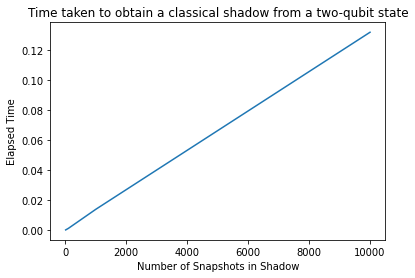

In [9]:
plt.plot([10, 100, 1000, 10000], elapsed_times)
plt.title("Time taken to obtain a classical shadow from a two-qubit state")
plt.xlabel("Number of Snapshots in Shadow")
plt.ylabel("Elapsed Time")
plt.show()

In [10]:
def snapshot_state(b_list, obs_list):
    """
    Helper function for `shadow_state_reconstruction` that reconstructs
     a state from a single snapshot in a shadow.

    Implements Eq. (S44) from https://arxiv.org/pdf/2002.08953.pdf

    Args:
        b_list (array): The list of classical outcomes for the snapshot.
        obs_list (array): Indices for the applied Pauli measurement.

    Returns:
        Numpy array with the reconstructed snapshot.
    """
    num_qubits = len(b_list)

    # computational basis states
    zero_state = np.array([[1, 0], [0, 0]])
    one_state = np.array([[0, 0], [0, 1]])

    # local qubit unitaries
    phase_z = Sdag(0).get_matrix()
    hadamard = H(0).get_matrix()
    identity = Identity(0).get_matrix()

    # undo the rotations that were added implicitly to the circuit for the Pauli measurements
    unitaries = [hadamard, hadamard @ phase_z, identity]

    # reconstructing the snapshot state from local Pauli measurements
    rho_snapshot = [1]
    for i in range(num_qubits):
        state = zero_state if b_list[i] == 1 else one_state
        U = unitaries[int(obs_list[i])]

        # applying Eq. (S44)
        local_rho = 3 * (U.conj().T @ state @ U) - identity
        rho_snapshot = np.kron(rho_snapshot, local_rho)

    return rho_snapshot


In [11]:
def shadow_state_reconstruction(shadow):
    """
    Reconstruct a state approximation as an average over all snapshots in the shadow.

    Args:
        shadow (tuple): A shadow tuple obtained from `calculate_classical_shadow`.

    Returns:
        Numpy array with the reconstructed quantum state.
    """
    num_snapshots, num_qubits = shadow[0].shape

    # classical values
    b_lists, obs_lists = shadow

    # Averaging over snapshot states.
    shadow_rho = np.zeros((2 ** num_qubits, 2 ** num_qubits), dtype=complex)
    for i in range(num_snapshots):
        shadow_rho += snapshot_state(b_lists[i], obs_lists[i])

    return shadow_rho / num_snapshots

In [12]:
num_qubits = 2

# circuit to create a Bell state and measure it in
def bell_state_circuit(ns, num_qubits, unitary_ids, unitary_ensemble):
    shots = 1
    state = QuantumState(num_qubits)
    state.set_zero_state()
    H(0).update_quantum_state(state)
    CNOT(0, 1).update_quantum_state(state)

    for i in range(num_qubits):
        if int(unitary_ids[ns, i]) == 1:
            Sdag(i).update_quantum_state(state)
            H(i).update_quantum_state(state)
        else:
            unitary_ensemble[int(unitary_ids[ns, i])](i).update_quantum_state(state)
        res = int(format(state.sampling(shots)[0], "b")) 
        res_len = len(str(res))
        if not (res_len == num_qubits):
            required_0 = num_qubits - res_len
            res = list(("0" * required_0 + str(res))[::-1])
        else:
            res = list((str(res))[::-1])

        for j in range(num_qubits):
            if res[j] == "0":
                res[j] = 1
            else:
                res[j] = -1

    return res

In [13]:
num_snapshots = 1000

shadow = calculate_classical_shadow(bell_state_circuit, num_snapshots, num_qubits)
print(shadow[0])
print(shadow[1])

[[ 1.  1.]
 [-1.  1.]
 [-1. -1.]
 ...
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]]
[[0 1]
 [1 2]
 [2 2]
 ...
 [2 2]
 [0 2]
 [1 2]]


In [14]:
shadow_state = shadow_state_reconstruction(shadow)
print(np.round(shadow_state, decimals=6))

[[ 0.514 +0.j     -0.006 -0.003j   0.1005-0.0015j  0.4725+0.063j ]
 [-0.006 +0.003j  -0.0155+0.j      0.    +0.0315j -0.0435+0.021j ]
 [ 0.1005+0.0015j  0.    -0.0315j  0.0025+0.j      0.021 +0.0285j]
 [ 0.4725-0.063j  -0.0435-0.021j   0.021 -0.0285j  0.499 +0.j    ]]


In [15]:
bell_state = np.array([[0.5, 0, 0, 0.5], [0, 0, 0, 0], [0, 0, 0, 0], [0.5, 0, 0, 0.5]])

In [16]:
def operator_2_norm(R):
    """
    Calculate the operator 2-norm.

    Args:
        R (array): The operator whose norm we want to calculate.

    Returns:
        Scalar corresponding to the norm.
    """
    return np.sqrt(np.trace(R.conjugate().transpose() @ R))


# Calculating the distance between ideal and shadow states.
operator_2_norm(bell_state - shadow_state)

(0.19835952208048901-2.8749464079733737e-19j)

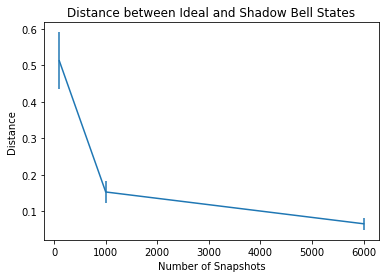

In [17]:
number_of_runs = 10
snapshots_range = [100, 1000, 6000]
distances = np.zeros((number_of_runs, len(snapshots_range)))

# run the estimation multiple times so that we can include error bars
for i in range(number_of_runs):
    for j, num_snapshots in enumerate(snapshots_range):
        shadow = calculate_classical_shadow(bell_state_circuit, num_snapshots, num_qubits)
        shadow_state = shadow_state_reconstruction(shadow)

        distances[i, j] = np.real(operator_2_norm(bell_state - shadow_state))

plt.errorbar(
    snapshots_range,
    np.mean(distances, axis=0),
    yerr=np.std(distances, axis=0),
)
plt.title("Distance between Ideal and Shadow Bell States")
plt.xlabel("Number of Snapshots")
plt.ylabel("Distance")
plt.show()

In [29]:
def estimate_shadow_observable(shadow, observable, k=10): # observable = [[0, 0], [0, 1]]
    shadow_size, num_qubits = shadow[0].shape
    
    target_obs = observable[0]
    target_locs = observable[1]

    b_lists, obs_lists = shadow
    # b_lists =
    #   [[1, -1, ...],
    #    [1, 1,  ...],
    #        ：
    #    [1, 1,  ...]](results of a measurement)
    # obs_lists =
    #   [[0, 1, ...],
    #    [2, 0, ...],
    #        ：
    #    [2, 1, ...]](unidary_ind)
    means = []

    for i in range(0, shadow_size, shadow_size // k):# counting k chunks whose size are [N/k] from i=0 to i=k 
        b_lists_k, obs_lists_k = (b_lists[i:(i+shadow_size // k)], obs_lists[i:(i+shadow_size // k)])

        indices = np.all(obs_lists_k[:, target_locs] == target_obs, axis=1)# this is done by going through each row.(↓→)
        # "obs_lists_k[:, target_locs]" picks colums which "target_locs" indicate with all rows. => chosing qubits that observable(argument) operates from "obs_lists_k"
        # [True, False, False, ..., True]  (k)
        
        # catch the edge case where there is no match in the chunk
        if sum(indices) > 0:# if there was at least one shadow that had exactly the same indices(measurement) as target_obs has.
            # take the product and sum
            product = np.prod(b_lists_k[indices][:, target_locs], axis=1)# picking b_list that had exactly the same indices(measurement) in "obs_lists_k" as "target_obs" has.(↓→) ########
            # [1, -1, ...] (number of "True" in "indices")
            means.append(np.sum(product) / sum(indices))# getting average through number of the valid shadow in chunk.
        else:# if there are no shadow that had exactly the same indices(measurement) in "obs_lists_k" as "target_obs" has. 
            means.append(0)# As soon as something like "PU†|b><b|U = ZH|b><b|H = 0"(when observable and measurement don't match) happens, the shadow in the chunk results in 0.

    return np.median(means)

In [30]:
def prepare_observable(num_qubits):
    box = []
    for i in range(num_qubits-1):
        box.append([[0, i], [0, (i+1)]])
        box.append([[1, i], [1, (i+1)]])
        box.append([[2, i], [2, (i+1)]])
    return box

In [31]:
def shadow_bound(error, observables, failure_rate=0.01):
    """
    Calculate the shadow bound for the Pauli measurement scheme.

    Implements Eq. (S13) from https://arxiv.org/pdf/2002.08953.pdf

    Args:
        error (float): The error on the estimator.
        observables (list) : List of matrices corresponding to the observables we intend to
            measure.
        failure_rate (float): Rate of failure for the bound to hold.

    Returns:
        An integer that gives the number of samples required to satisfy the shadow bound and
        the chunk size required attaining the specified failure rate.
    """
    M = len(observables)
    K = 2 * np.log(2 * M / failure_rate)
    shadow_norm = (
        lambda op: np.linalg.norm(
            op - np.trace(op) / 2 ** int(np.log2(op.shape[0])), ord=np.inf
        )
        ** 2
    )
    N = 34 * max(shadow_norm(o) for o in observables) / error ** 2
    return int(np.ceil(N * K)), int(K)

In [32]:
num_qubits = 10

# the bases specified by the 'observable' keyword argument.
def state_circuit(ns, num_qubits, unitary_ids, unitary_ensemble):
    shots = 1
    seed = 2
    state = QuantumState(num_qubits)
    state.set_Haar_random_state(seed)
    for i in range(num_qubits):
        if int(unitary_ids[ns, i]) == 1:
            Sdag(i).update_quantum_state(state)
            H(i).update_quantum_state(state)
        else:
            unitary_ensemble[int(unitary_ids[ns, i])](i).update_quantum_state(state)
        res = int(format(state.sampling(shots)[0], "b")) 
        res_len = len(str(res))
        if not (res_len == num_qubits):
            required_0 = num_qubits - res_len
            res = list(("0" * required_0 + str(res))[::-1])
        else:
            res = list((str(res))[::-1])

        for j in range(num_qubits):
            if res[j] == "0":
                res[j] = 1
            else:
                res[j] = -1

    return res

In [33]:
list_of_observables =[merge(X(i), X(i + 1)) for i in range(num_qubits - 1)] + [merge(Y(i), Y(i + 1)) for i in range(num_qubits - 1)] + [merge(Z(i), Z(i + 1)) for i in range(num_qubits - 1)]

In [34]:
 observables=[o.get_matrix() for o in list_of_observables]

In [35]:
shadow_size_bound, k = shadow_bound(
    error=2e-1, observables=observables
)
shadow_size_bound

14611

In [36]:
# create a grid of errors
epsilon_grid = [1 - 0.1 * x for x in range(9)]
shadow_sizes = []
estimates = []

for error in epsilon_grid:
    # get the number of samples needed so that the absolute error < epsilon.
    shadow_size_bound, k = shadow_bound(
        error=error, observables=[o.get_matrix() for o in list_of_observables]
    )
    shadow_sizes.append(shadow_size_bound)
    print(f"{shadow_size_bound} samples required ")
    # calculate a shadow of the appropriate size
    shadow = calculate_classical_shadow(state_circuit, shadow_size_bound, num_qubits)

    # estimate all the observables in O
    estimates.append([estimate_shadow_observable(shadow, o, k=k) for o in prepare_observable(num_qubits)])

585 samples required 
722 samples required 
914 samples required 
1193 samples required 
1624 samples required 
2338 samples required 
3653 samples required 
6494 samples required 
14611 samples required 


In [41]:
# change the simulator to be the exact one.
seed = 4
pauli_dic = {0:"X", 1:"Y", 2:"Z"}
expval_exact = []
t = prepare_observable(num_qubits)
for i in range(len(t)):
    state = QuantumState(num_qubits)
    state.set_Haar_random_state(seed)
    measurement = Observable(num_qubits)
    A = str(pauli_dic[t[i][0][0]])
    B = str(t[i][0][1])
    C = str(pauli_dic[t[i][1][0]])
    D = str(t[i][1][1])
    op = f'{A} {B} {C} {D}'
    measurement.add_operator(1.0,op)
    res = measurement.get_expectation_value(state)
    expval_exact.append(res)

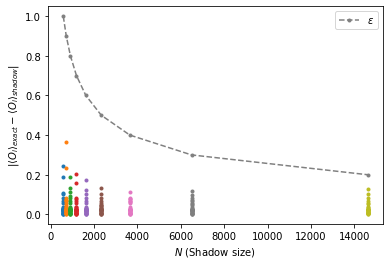

In [43]:
for j, error in enumerate(epsilon_grid):
    plt.scatter(
        [shadow_sizes[j] for _ in estimates[j]],
        [np.abs(obs - estimates[j][i]) for i, obs in enumerate(expval_exact)],
        marker=".",
    )
plt.plot(
    shadow_sizes,
    [e for e in epsilon_grid],
    linestyle="--",
    color="gray",
    label=rf"$\epsilon$",
    marker=".",
)
plt.xlabel(r"$N$ (Shadow size) ")
plt.ylabel(r"$|\langle O_i \rangle_{exact} - \langle O_i \rangle_{shadow}|$")
plt.legend()
plt.show()